In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.clients.fdsn import Client
from scipy.signal import spectrogram
import time

import IPython.display as ipd

import tensorflow as tf
import keras
from keras.layers import Input, Dense, RepeatVector, TimeDistributed
from keras.layers import CuDNNLSTM as LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from keras import regularizers

Using TensorFlow backend.


# Neural network based feature extraction of hawaiian earthquakes

## Some ideas how to do it
1. LSTM autoencoder to get latent representation, cluster on latent vector
 - sparse autoencoder


### Load the data extracted in other notebook from this directory

In [2]:
spectrograms = np.load('hawaii_2016_2018_mag3_spectrograms.npy')

In [3]:
print(spectrograms.shape)
n_features, n_timesteps, n_samples = spectrograms.shape
print("n_features: {} \nn_timesteps: {} \nn_samples: {}".format(n_features, n_timesteps,n_samples))
spectrograms = spectrograms.T
print("Reshaped for keras")
print(spectrograms.shape)

(21, 45, 2228)
n_features: 21 
n_timesteps: 45 
n_samples: 2228
Reshaped for keras
(2228, 45, 21)


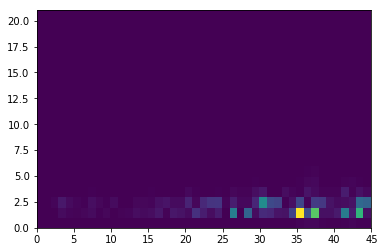

In [4]:
plt.pcolormesh(spectrograms[100,:,:].T)

### Create sparse autoencoder model

from https://blog.keras.io/building-autoencoders-in-keras.html
KL regularizer adapted from https://stackoverflow.com/questions/43599082/kl-divergence-in-kerastensorflow-backend

In [79]:
KL_divergence = keras.losses.kullback_leibler_divergence
K = keras.backend

class KL_regularizer():
    def __init__(self, lamb=0.005, sparsity=0.05):
        #needed for get_config
        self.lamb_ = lamb
        self.sparsity_ = sparsity
        
        # needed for calcs in backend
        self.lamb = K.constant(lamb) 
        self.sparsity = K.constant(sparsity)
        
    def __call__(self, inputs):
        means = K.mean(inputs, axis=0)
        return self.lamb * (KL_divergence(self.sparsity, means) +
                            KL_divergence(1 - self.sparsity, 1 - means))
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    def get_config(self):
        return {'lambda': float(self.lamb_),
                'sparsity target': float(self.sparsity_)}

def create_model(n_timesteps, n_features, latent_dim):
    inputs = Input(shape=(n_timesteps, n_features), name='input')
    #encoded = LSTM(latent_dim,  activity_regularizer=regularizers.l1(10e-5), name='encoder_LSTM2')(inputs)
    encoded = LSTM(latent_dim,  activity_regularizer=KL_regularizer(1e-5,0.05), name='encoder_LSTM2')(inputs)
    
    decoded = RepeatVector(n_timesteps, name='repeat_vector')(encoded)
    decoded = LSTM(latent_dim, return_sequences=True, name='decoder_LSTM1')(decoded)
    decoded = TimeDistributed(Dense(n_features))(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    adam = Adam(lr=0.01)
    sequence_autoencoder.compile(optimizer=adam, loss='mse')
    
    return (sequence_autoencoder, encoder)

In [82]:
latent_dimensions = 200

autoencoder, encoder = create_model(n_timesteps, n_features, latent_dimensions)

In [ ]:
model_name = "sparse.200latent.{}".format(time.time())

checkpoint = ModelCheckpoint('./weights/sparse_autoencoder/sparse.200latent.KLe-5_05.weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                                             monitor='val_loss', 
                                             verbose=0, 
                                             save_best_only=True)

autoencoder.load_weights('./weights/sparse_autoencoder/sparse.200latent.KLe-5_05.weights.25473-0.00.hdf5')

def sched(epoch, lr):
    if epoch < 100000:
        return 0.001
    elif epoch < 30000:
        return 0.0003
    else:
        return 0.0001

    
lr_scheduler = LearningRateScheduler(sched)

tensorboard = TensorBoard(log_dir='./logs/{}'.format(model_name))

autoencoder.fit(spectrograms, spectrograms,
                epochs=300000,
                batch_size=512,
                shuffle=True,
                validation_data=(spectrograms, spectrograms),
                callbacks=[checkpoint, tensorboard, lr_scheduler])

### Show a reconstructed spectrogram

In [88]:
reconstructed = autoencoder.predict(spectrograms)

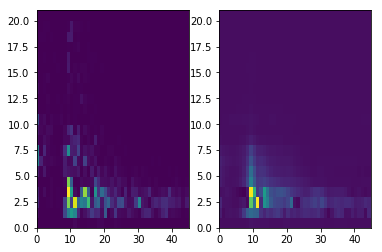

In [96]:
j = 0

f, (ax1, ax2) = plt.subplots(1,2)
ax1.pcolormesh(spectrograms[j,:,:].T)
#ax1.title('Original spectrogram')

ax2.pcolormesh(reconstructed[j,:,:].T)
#ax2.title('Reconstructed spectrogram')

In [90]:
latent_vectors = encoder.predict(spectrograms)

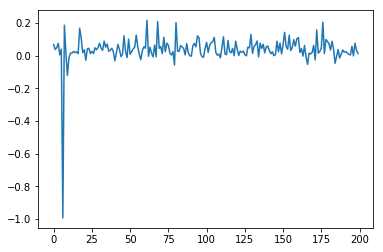

In [91]:
plt.plot(latent_vectors[j])

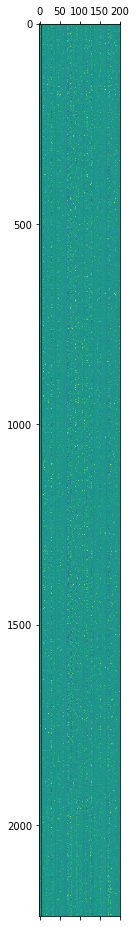

In [92]:
plt.matshow(latent_vectors[:])

In [20]:
print(latent_)

'C:\\Users\\Nate\\seismic-autoencoders'